In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

In [2]:
## import data
df = pd.read_csv('DATA_update.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

        Date      Open      High       Low     Close      Volume       NASDAQ  \
0 2010-07-01  9.082143  9.100000  8.686429  8.874286  1022896000  2101.360107   
1 2010-07-02  8.946071  8.961786  8.685714  8.819286   693842800  2091.790039   
2 2010-07-06  8.964286  9.028571  8.791429  8.879643   615235600  2093.879883   
3 2010-07-07  8.946071  9.241786  8.919643  9.238214   654556000  2159.469971   
4 2010-07-08  9.374286  9.389286  9.103214  9.217500   738144400  2175.399902   

          NYSE      S&P 500      FTSE100  ...  RUSSELL2000     HENG SENG  \
0  6462.029785  1027.369995  4805.799805  ...   604.760010           NaN   
1  6434.810059  1022.580017  4838.100098  ...   598.969971  19905.320312   
2  6486.089844  1028.060059  4965.000000  ...   590.030029  20084.119141   
3  6685.779785  1060.270020  5014.799805  ...   611.659973  19857.070312   
4  6755.810059  1070.250000  5105.500000  ...   620.270020  20050.560547   

           SSE  Crude Oil         Gold        VIX  USD i

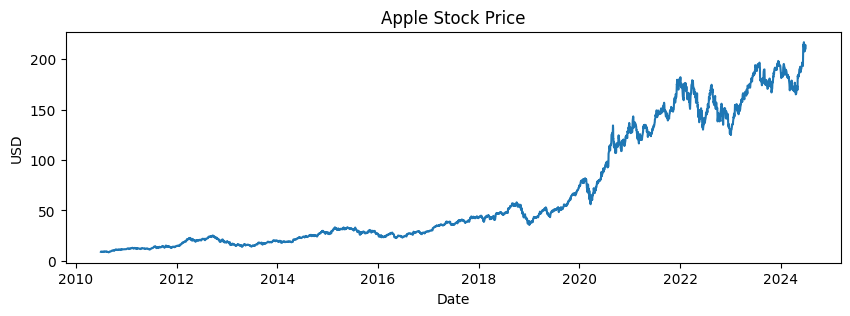

In [3]:
# Create Apple stock price plot
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(df['Date'], df['Close'], label='Apple stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Apple Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [4]:
# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

In [5]:
#Drop the first 21 rows
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)

In [6]:
#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [7]:
#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

In [8]:
print(Final_data.head())

        Date      Open      High       Low     Close     Volume       NASDAQ  \
0 2010-07-30  9.138929  9.275000  9.103571  9.187500  448210000  2254.699951   
1 2010-08-02  9.301429  9.378214  9.272143  9.351786  428055600  2295.360107   
2 2010-08-03  9.321786  9.402143  9.265000  9.354643  417653600  2283.520020   
3 2010-08-04  9.387143  9.438571  9.296786  9.392143  420375200  2303.570068   
4 2010-08-05  9.347500  9.399286  9.305357  9.346429  289097200  2293.060059   

          NYSE      S&P 500      FTSE100  ...  upper_band  lower_band  \
0  6998.990234  1101.599976  5258.000000  ...    9.471127    8.739587   
1  7174.899902  1125.859985  5397.100098  ...    9.479903    8.776287   
2  7146.990234  1120.459961  5396.500000  ...    9.494345    8.812832   
3  7182.140137  1127.239990  5386.200195  ...    9.532184    8.823802   
4  7174.270020  1125.810059  5365.799805  ...    9.545201    8.821091   

        EMA  logmomentum  absolute of 3 comp  angle of 3 comp  \
0  9.211011    

In [9]:
def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators for Apple - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')
       
       plt.legend()
       plt.show()

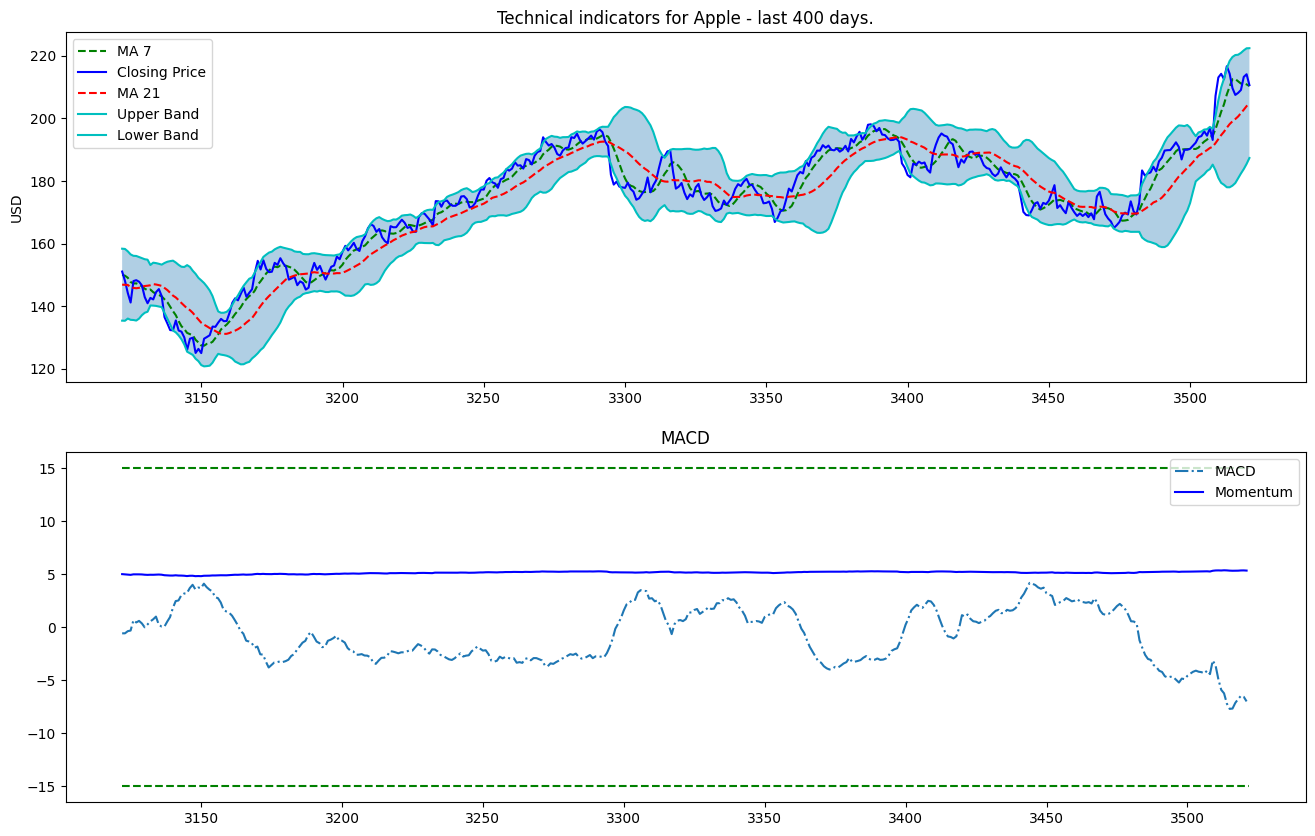

In [10]:
plot_technical_indicators(T_df, 400)

In [11]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Apple (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

/home/vscode/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


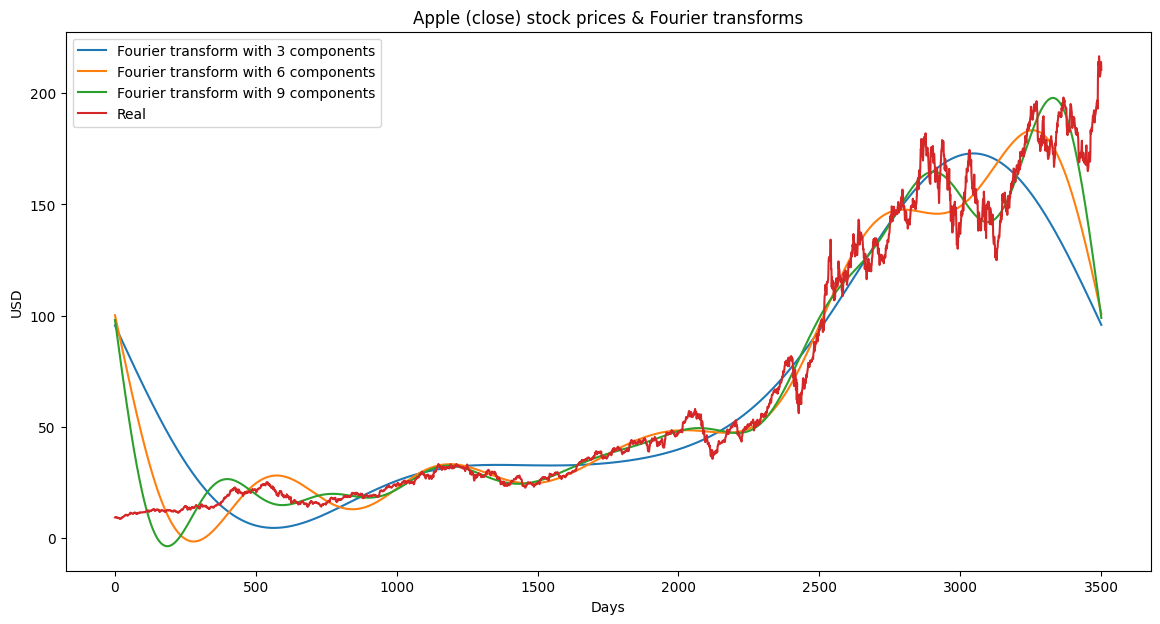

In [12]:
plot_Fourier(dataset)